# Investigating regional SAE features

In [1]:
import torch
import numpy as np
import pandas as pd
import anndata as ad
import multiDGD
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os

os.chdir('../..')
os.getcwd()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
data = ad.read_h5ad('/projects/heads/data/singlecell/human_bonemarrow.h5ad')
data = data[data.obs["train_val_test"] == "train"]
df_celltypes = pd.read_csv("03_results/reports/human_bonemarrow_l20_h2-3_test50e_pca.csv")

activations = torch.load('03_results/reports/sae_model_10000_l1-1e-3_lr-1e-4_500epochs_activations.pt')

/tmp/ipykernel_1123808/521900397.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  activations = torch.load('03_results/reports/sae_model_10000_l1-1e-3_lr-1e-4_500epochs_a

In [3]:
# go through all cell types and compute each features mean activation and std for ct positive and negative
cell_types = [x for x in data.obs['cell_type'].unique()]
means_positive = torch.zeros((len(cell_types), activations.shape[1]))
se_positive = torch.zeros((len(cell_types), activations.shape[1]))
means_negative = torch.zeros((len(cell_types), activations.shape[1]))
se_negative = torch.zeros((len(cell_types), activations.shape[1]))
for i, ct in enumerate(cell_types):
    data_indices = data.obs['cell_type'] == ct
    activations_pos = activations[data_indices,:]
    activations_neg = activations[~data_indices,:]
    means_positive[i,:] = torch.mean(activations_pos, dim=0).detach().cpu()
    # compute the standard error of the mean
    se_positive[i,:] = torch.std(activations_pos, dim=0).detach().cpu() / math.sqrt(activations_pos.shape[0])
    means_negative[i,:] = torch.mean(activations_neg, dim=0).detach().cpu()
    se_negative[i,:] = torch.std(activations_neg, dim=0).detach().cpu() / math.sqrt(activations_neg.shape[0])
# that gives the "significant features" per cell type
significant_features = torch.BoolTensor((means_positive - means_negative) > 1.96*(se_positive + se_negative))
significances = (means_positive - means_negative) - 1.96*(se_positive + se_negative)
sum_significant_features = torch.sum(significant_features, dim=0)

###
# unique (local) vs shared (global) features, and there is a thing in the middle which I call regional
###
# all active features
active_features = (torch.where(torch.sum(activations, dim=0) != 0)[0]).tolist()
# local features are the ct specific ones
local_features = (torch.where(sum_significant_features == 1)[0]).tolist()
regional_features = (torch.where(sum_significant_features > 1)[0]).tolist()
# all remaining active features are global
global_features = list(set(active_features).difference(set(local_features).union(set(regional_features))))

print('{} active features, {} local features, {} regional features, {} global features'.format(len(active_features), len(local_features), len(regional_features), len(global_features)))

5318 active features, 908 local features, 1072 regional features, 3338 global features


In [16]:
# sort the regional features by which cell type has the highest significance

multi_ct_features = {}
multi_ct_feature_indices = torch.where(sum_significant_features > 1)[0]
for i, ct in enumerate(cell_types):
    ct_features_temp = torch.where(significant_features[i,:])[0]
    #ct_features_temp = torch.argsort(significances[i,:], descending=True)
    # only keep those that are also in the multi_ct_feature_indices
    ct_features_temp = list(set(list(ct_features_temp.numpy())).intersection(set(list(multi_ct_feature_indices.numpy()))))
    # argsort the ct features
    ct_features_temp = torch.tensor(ct_features_temp)
    ct_features_temp = ct_features_temp[torch.argsort(significances[i,ct_features_temp], descending=True)]
    multi_ct_features[ct] = ct_features_temp
    print('Cell type: {}, # unique features: {}'.format(ct, len(ct_features_temp)))

Cell type: Naive CD20+ B, # unique features: 168
Cell type: CD14+ Mono, # unique features: 223
Cell type: CD8+ T, # unique features: 114
Cell type: CD16+ Mono, # unique features: 292
Cell type: B1 B, # unique features: 180
Cell type: Lymph prog, # unique features: 251
Cell type: CD4+ T naive, # unique features: 175
Cell type: CD4+ T activated, # unique features: 150
Cell type: Erythroblast, # unique features: 329
Cell type: Normoblast, # unique features: 298
Cell type: NK, # unique features: 170
Cell type: ILC, # unique features: 215
Cell type: Transitional B, # unique features: 197
Cell type: G/M prog, # unique features: 301
Cell type: MK/E prog, # unique features: 238
Cell type: HSC, # unique features: 236
Cell type: pDC, # unique features: 245
Cell type: ID2-hi myeloid prog, # unique features: 271
Cell type: Proerythroblast, # unique features: 338
Cell type: Plasma cell, # unique features: 162
Cell type: cDC2, # unique features: 272
Cell type: CD8+ T naive, # unique features: 167


### plotting functions

In [24]:
rocket_r_colors = sns.color_palette('rocket_r', n_colors=256)
def plot_feature_grid(feat_ids, ct_name):
    if len(feat_ids) > 23:
        print("Too many features to plot")
        print("Only plotting the 23 most significant")
        feat_ids = feat_ids[:23]
    n = len(feat_ids)
    n_cols = min((n+1), 4)
    n_rows = math.ceil((n+1) / n_cols)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    # first plot is to show where the celltype is
    df_celltypes_temp = df_celltypes.copy()
    df_celltypes_temp[ct_name] = 0
    df_celltypes_temp.loc[data.obs["cell_type"].values == ct_name, ct_name] = 1
    # "zoom in" to the pca of the cell type
    # get min-max x and y values for the cell type
    #x_min = df_celltypes_temp.loc[df_celltypes_temp[ct_name] == 1, "PC 1"].min()
    #x_max = df_celltypes_temp.loc[df_celltypes_temp[ct_name] == 1, "PC 1"].max()
    #y_min = df_celltypes_temp.loc[df_celltypes_temp[ct_name] == 1, "PC 2"].min()
    #y_max = df_celltypes_temp.loc[df_celltypes_temp[ct_name] == 1, "PC 2"].max()
    df_celltypes_temp = df_celltypes_temp.sort_values(by=ct_name, ascending=True)
    if n_rows == 1:
        sns.scatterplot(data=df_celltypes_temp, x="PC 1", y="PC 2", hue=ct_name, s=2, alpha=0.7, ec=None, ax=axs[0], palette=[rocket_r_colors[0], rocket_r_colors[-1]])
        cbar_points = plt.scatter([], [], c=[], vmin=df_celltypes_temp[ct_name].min(), vmax=df_celltypes_temp[ct_name].max(), cmap='rocket_r')
        plt.colorbar(cbar_points, ax=axs[0], label=ct_name)
        #axs[0].set_xlim(x_min, x_max)
        #axs[0].set_ylim(y_min, y_max)
        axs[0].set_title(f"{ct_name} location")
        axs[0].get_legend().remove()
    else:
        sns.scatterplot(data=df_celltypes_temp, x="PC 1", y="PC 2", hue=ct_name, s=2, alpha=0.7, ec=None, ax=axs[0, 0], palette=[rocket_r_colors[0], rocket_r_colors[-1]])
        cbar_points = plt.scatter([], [], c=[], vmin=df_celltypes_temp[ct_name].min(), vmax=df_celltypes_temp[ct_name].max(), cmap='rocket_r')
        plt.colorbar(cbar_points, ax=axs[0, 0], label=ct_name)
        #axs[0, 0].set_xlim(x_min, x_max)
        #axs[0, 0].set_ylim(y_min, y_max)
        axs[0, 0].set_title(f"{ct_name} location")
        axs[0, 0].get_legend().remove()
    for i, feat_id in enumerate(feat_ids):
        row = (i+1) // n_cols
        col = (i+1) % n_cols
        df_celltypes_temp = df_celltypes.copy()
        df_celltypes_temp["feature"] = activations[:,feat_id].detach().cpu().numpy()
        # sort by the feature activation
        df_celltypes_temp = df_celltypes_temp.sort_values(by='feature', ascending=True)
        #sns.scatterplot(data=df_celltypes_temp, x="PC 1", y="PC 2", hue='feature', size='feature', s=1, alpha=0.7, ec=None, ax=axs[row, col], palette='rocket_r')
        if n_rows == 1:
            sns.scatterplot(data=df_celltypes_temp, x="PC 1", y="PC 2", hue='feature', size='feature', s=1, alpha=0.7, ec=None, ax=axs[col], palette='rocket_r', sizes=(2,20))
            axs[col].set_title(f"Feature {feat_id}")
            # remove the ticks
            axs[col].set_xticks([])
            axs[col].set_yticks([])
            # set limits
            #axs[col].set_xlim(x_min, x_max)
            #axs[col].set_ylim(y_min, y_max)
            # put the leend outside the plot
            cbar_points = plt.scatter([], [], c=[], vmin=df_celltypes_temp['feature'].min(), vmax=df_celltypes_temp['feature'].max(), cmap='rocket_r')
            plt.colorbar(cbar_points, ax=axs[col], label='Activation')
            # remove the normal legend
            axs[col].get_legend().remove()
        else:
            sns.scatterplot(data=df_celltypes_temp, x="PC 1", y="PC 2", hue='feature', size='feature', s=1, alpha=0.7, ec=None, ax=axs[row, col], palette='rocket_r', sizes=(2,20))
            axs[row, col].set_title(f"Feature {feat_id}")
            # remove the ticks
            axs[row, col].set_xticks([])
            axs[row, col].set_yticks([])
            # set limits
            #axs[row, col].set_xlim(x_min, x_max)
            #axs[row, col].set_ylim(y_min, y_max)
            # put the leend outside the plot
            cbar_points = plt.scatter([], [], c=[], vmin=df_celltypes_temp['feature'].min(), vmax=df_celltypes_temp['feature'].max(), cmap='rocket_r')
            plt.colorbar(cbar_points, ax=axs[row, col], label='Activation')
            # remove the normal legend
            axs[row, col].get_legend().remove()
    plt.tight_layout()

def plot_multi_by_ct(ct_of_interest):
    feature_significance = []

    for feat in multi_ct_features[ct_of_interest]:
        feat_activations = activations[:,feat]
        ct_indices = data.obs['cell_type'] == ct_of_interest
        ct_mean = torch.mean(feat_activations[ct_indices])
        ct_se = torch.std(feat_activations[ct_indices]) / math.sqrt(len(ct_indices))
        other_mean = torch.mean(feat_activations[~ct_indices])
        other_se = torch.std(feat_activations[~ct_indices]) / math.sqrt(len(~ct_indices))
        mean_diff = ct_mean - other_mean
        total_se = ct_se + other_se
        significance = mean_diff - 1.96*total_se
        feature_significance.append(significance)
        #print(f'Feature {feat}: {significance} (signif), {ct_mean} (ct), {other_mean} (other)')

    # now sort the features by significance
    sorted_features = [x for _, x in sorted(zip(feature_significance, multi_ct_features[ct_of_interest]), reverse=True)]

    plot_feature_grid(sorted_features, ct_of_interest)

## plot some regional features

### B cells

Too many features to plot
Only plotting the 23 most significant


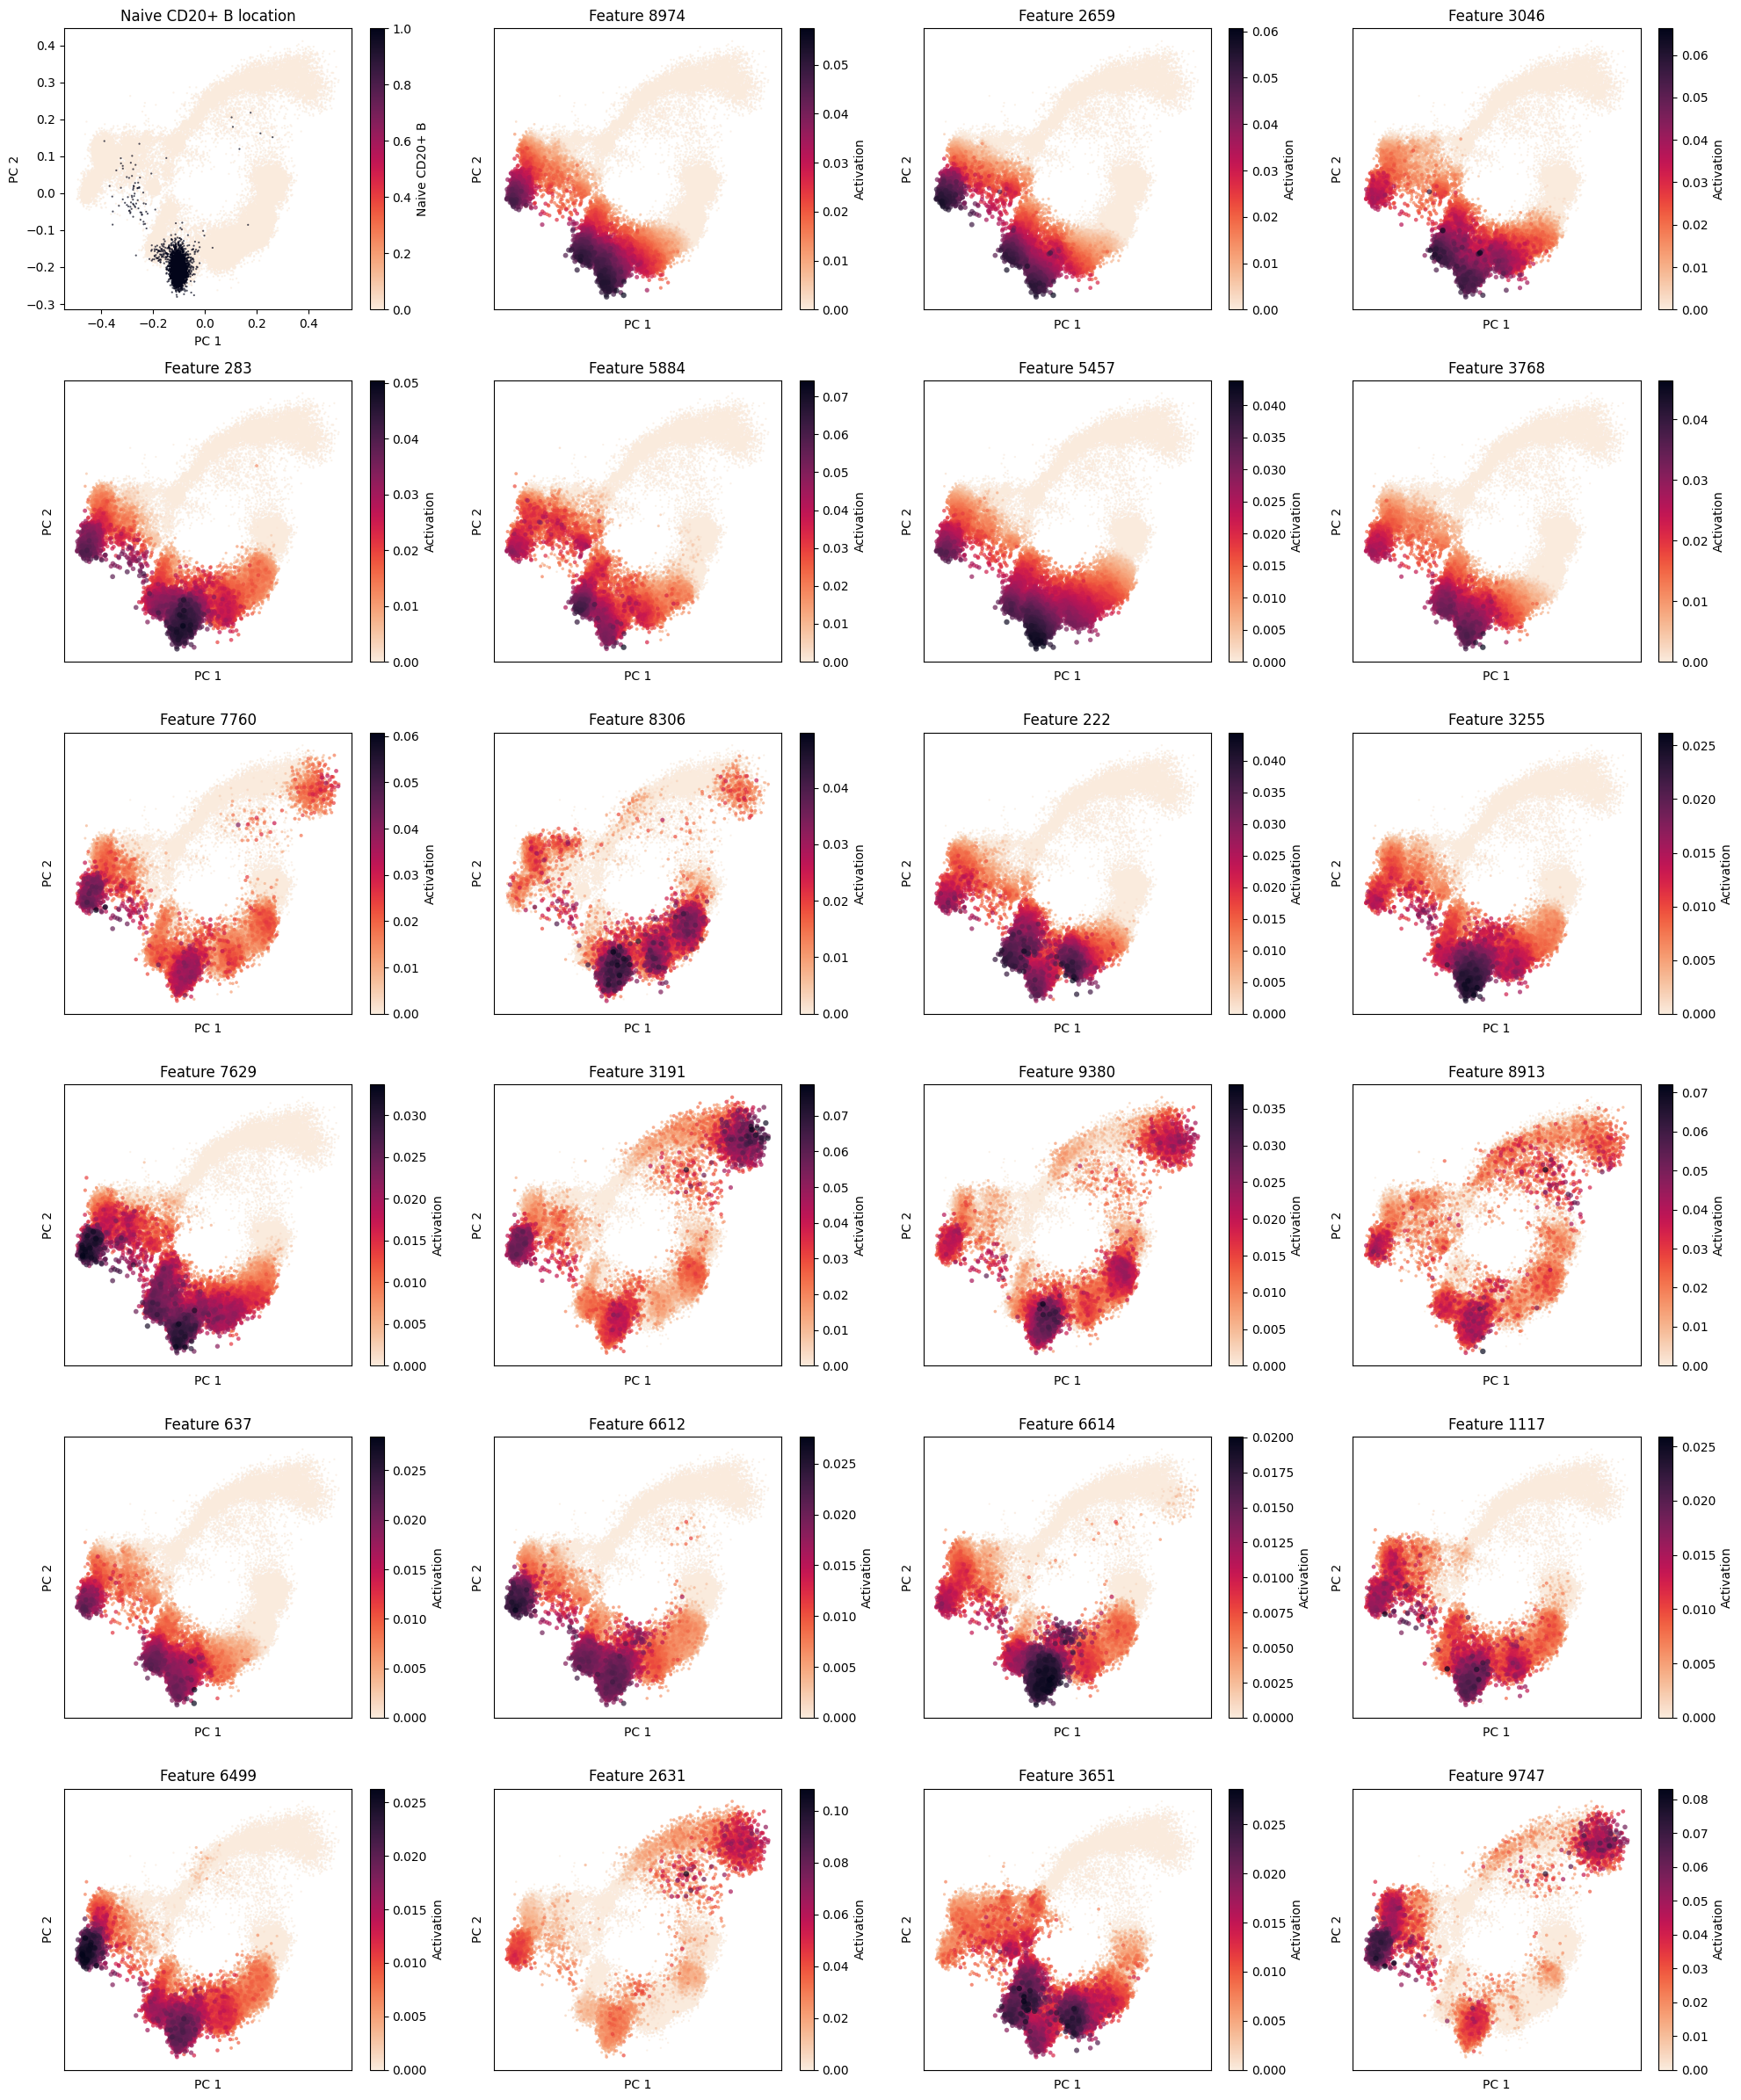

In [25]:
plot_multi_by_ct('Naive CD20+ B')

### Monocytes

Too many features to plot
Only plotting the 23 most significant


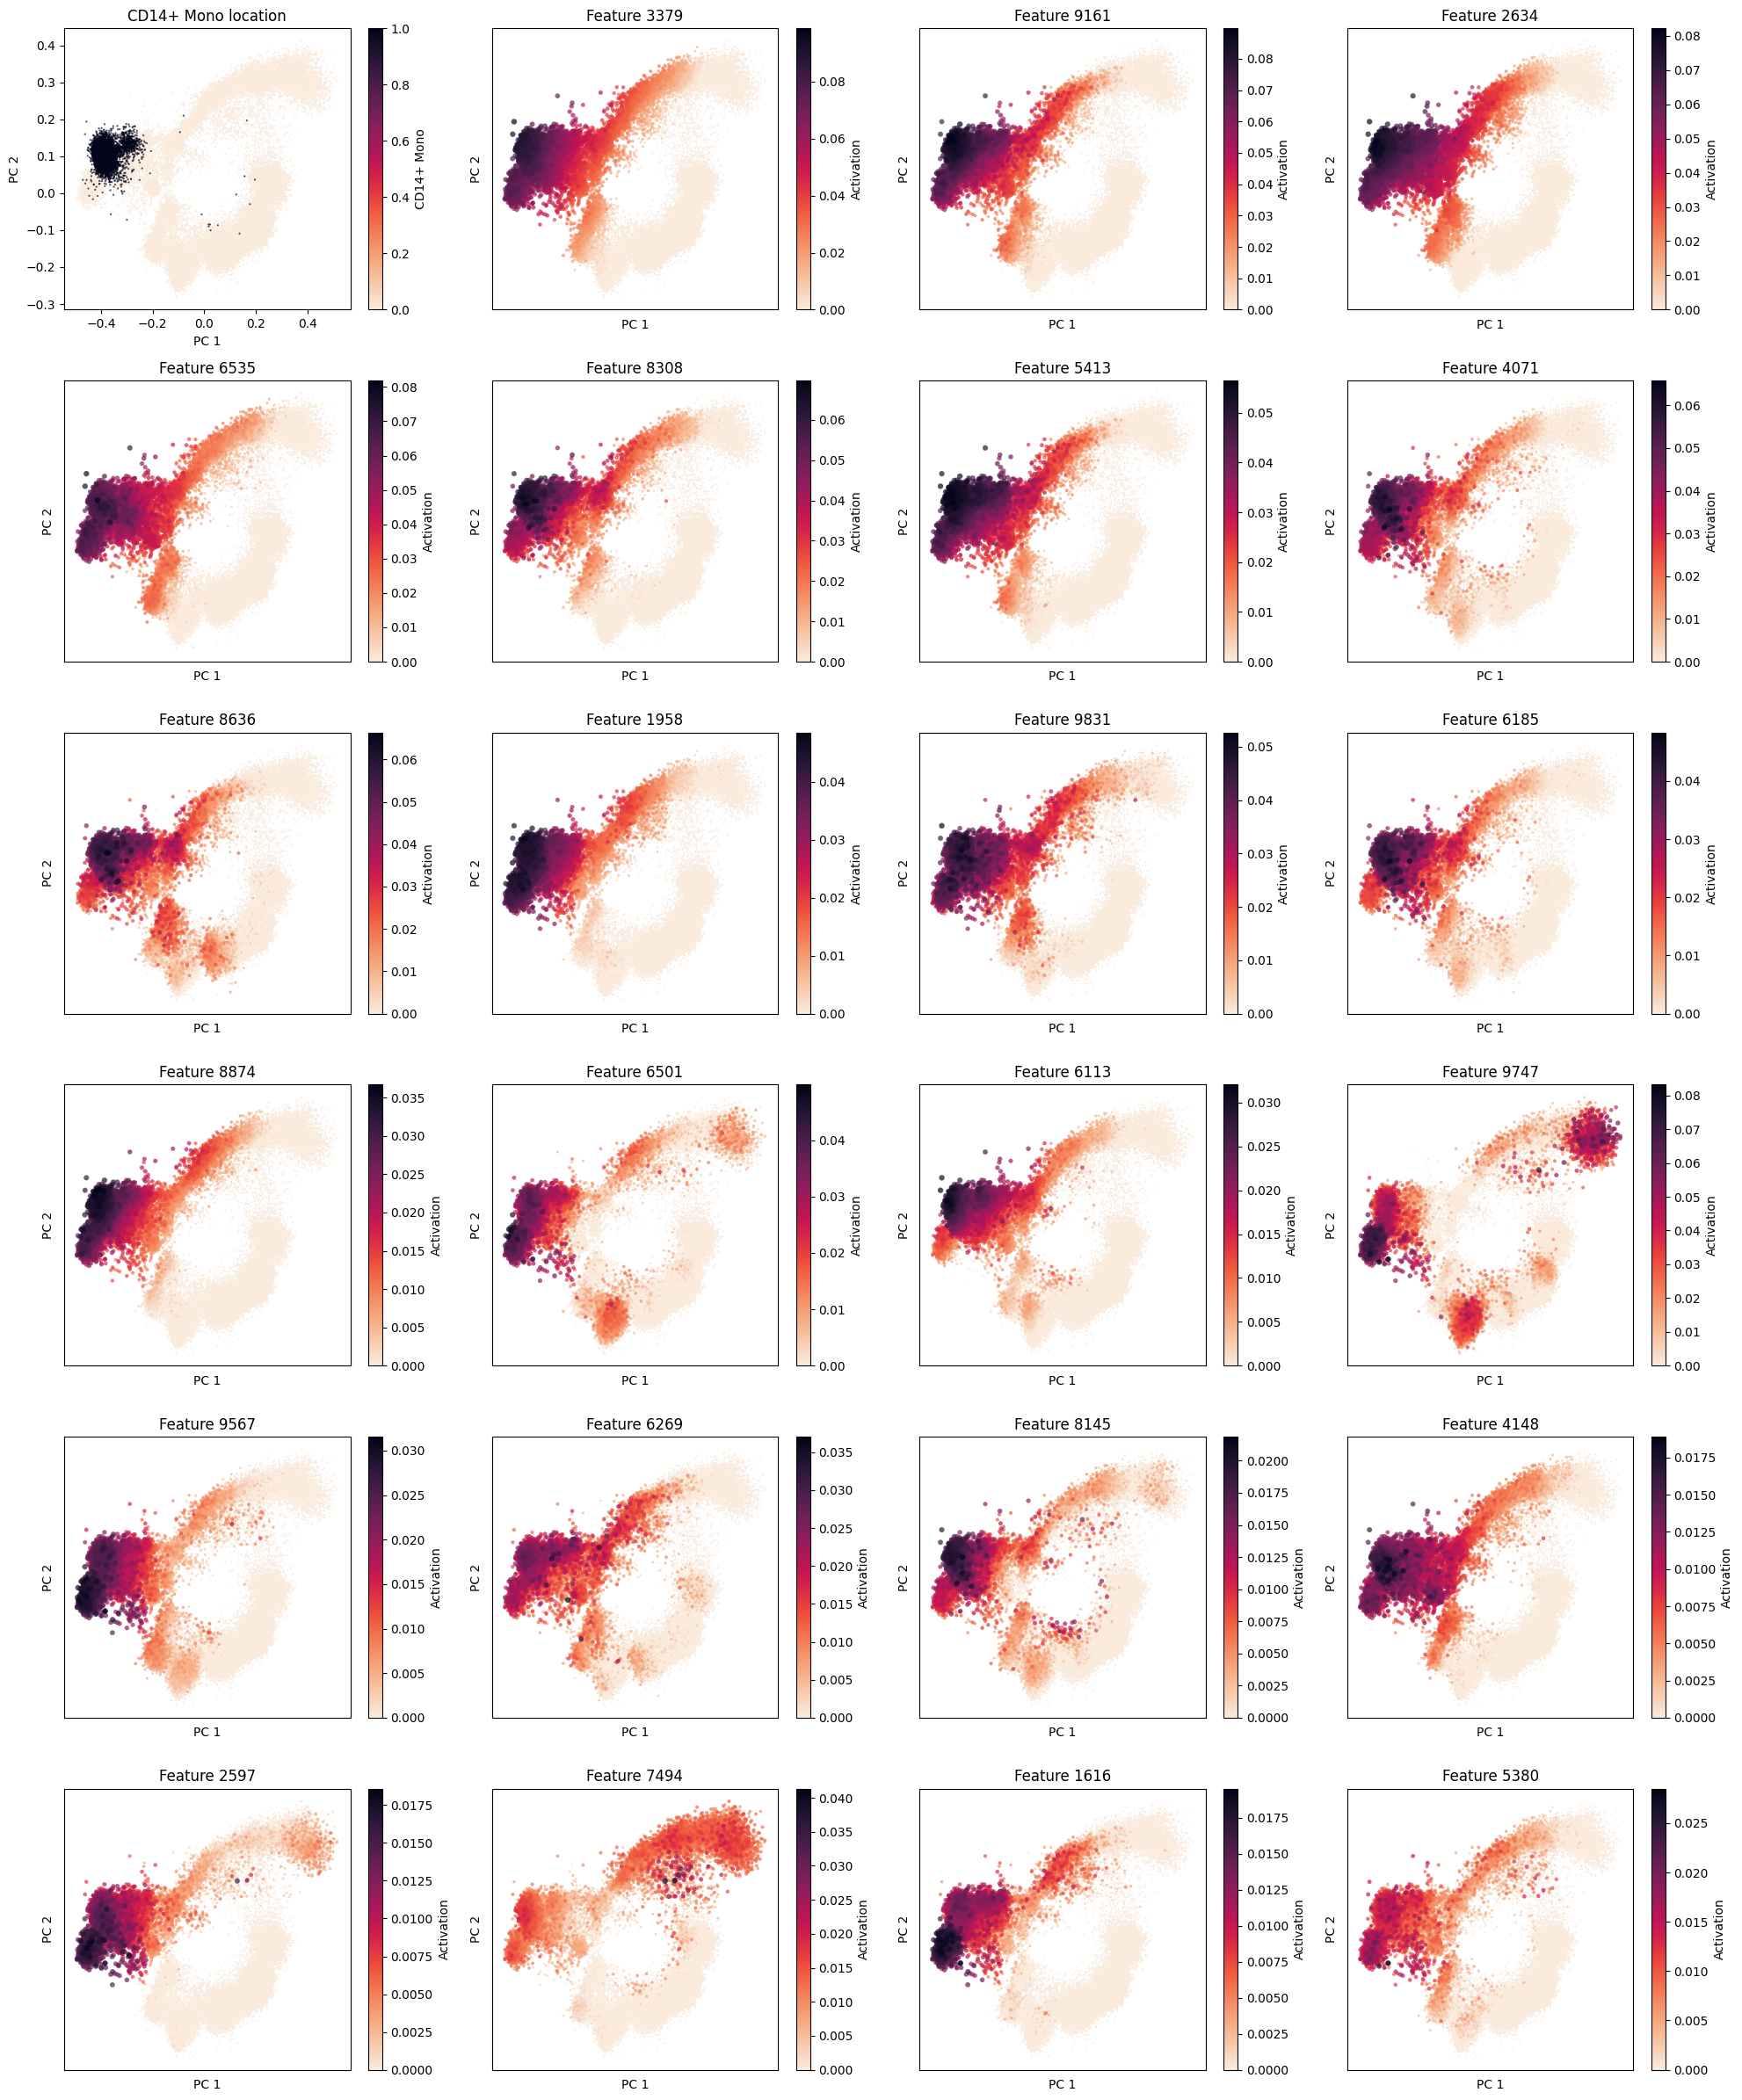

In [26]:
plot_multi_by_ct('CD14+ Mono')

### T cells

Too many features to plot
Only plotting the 23 most significant


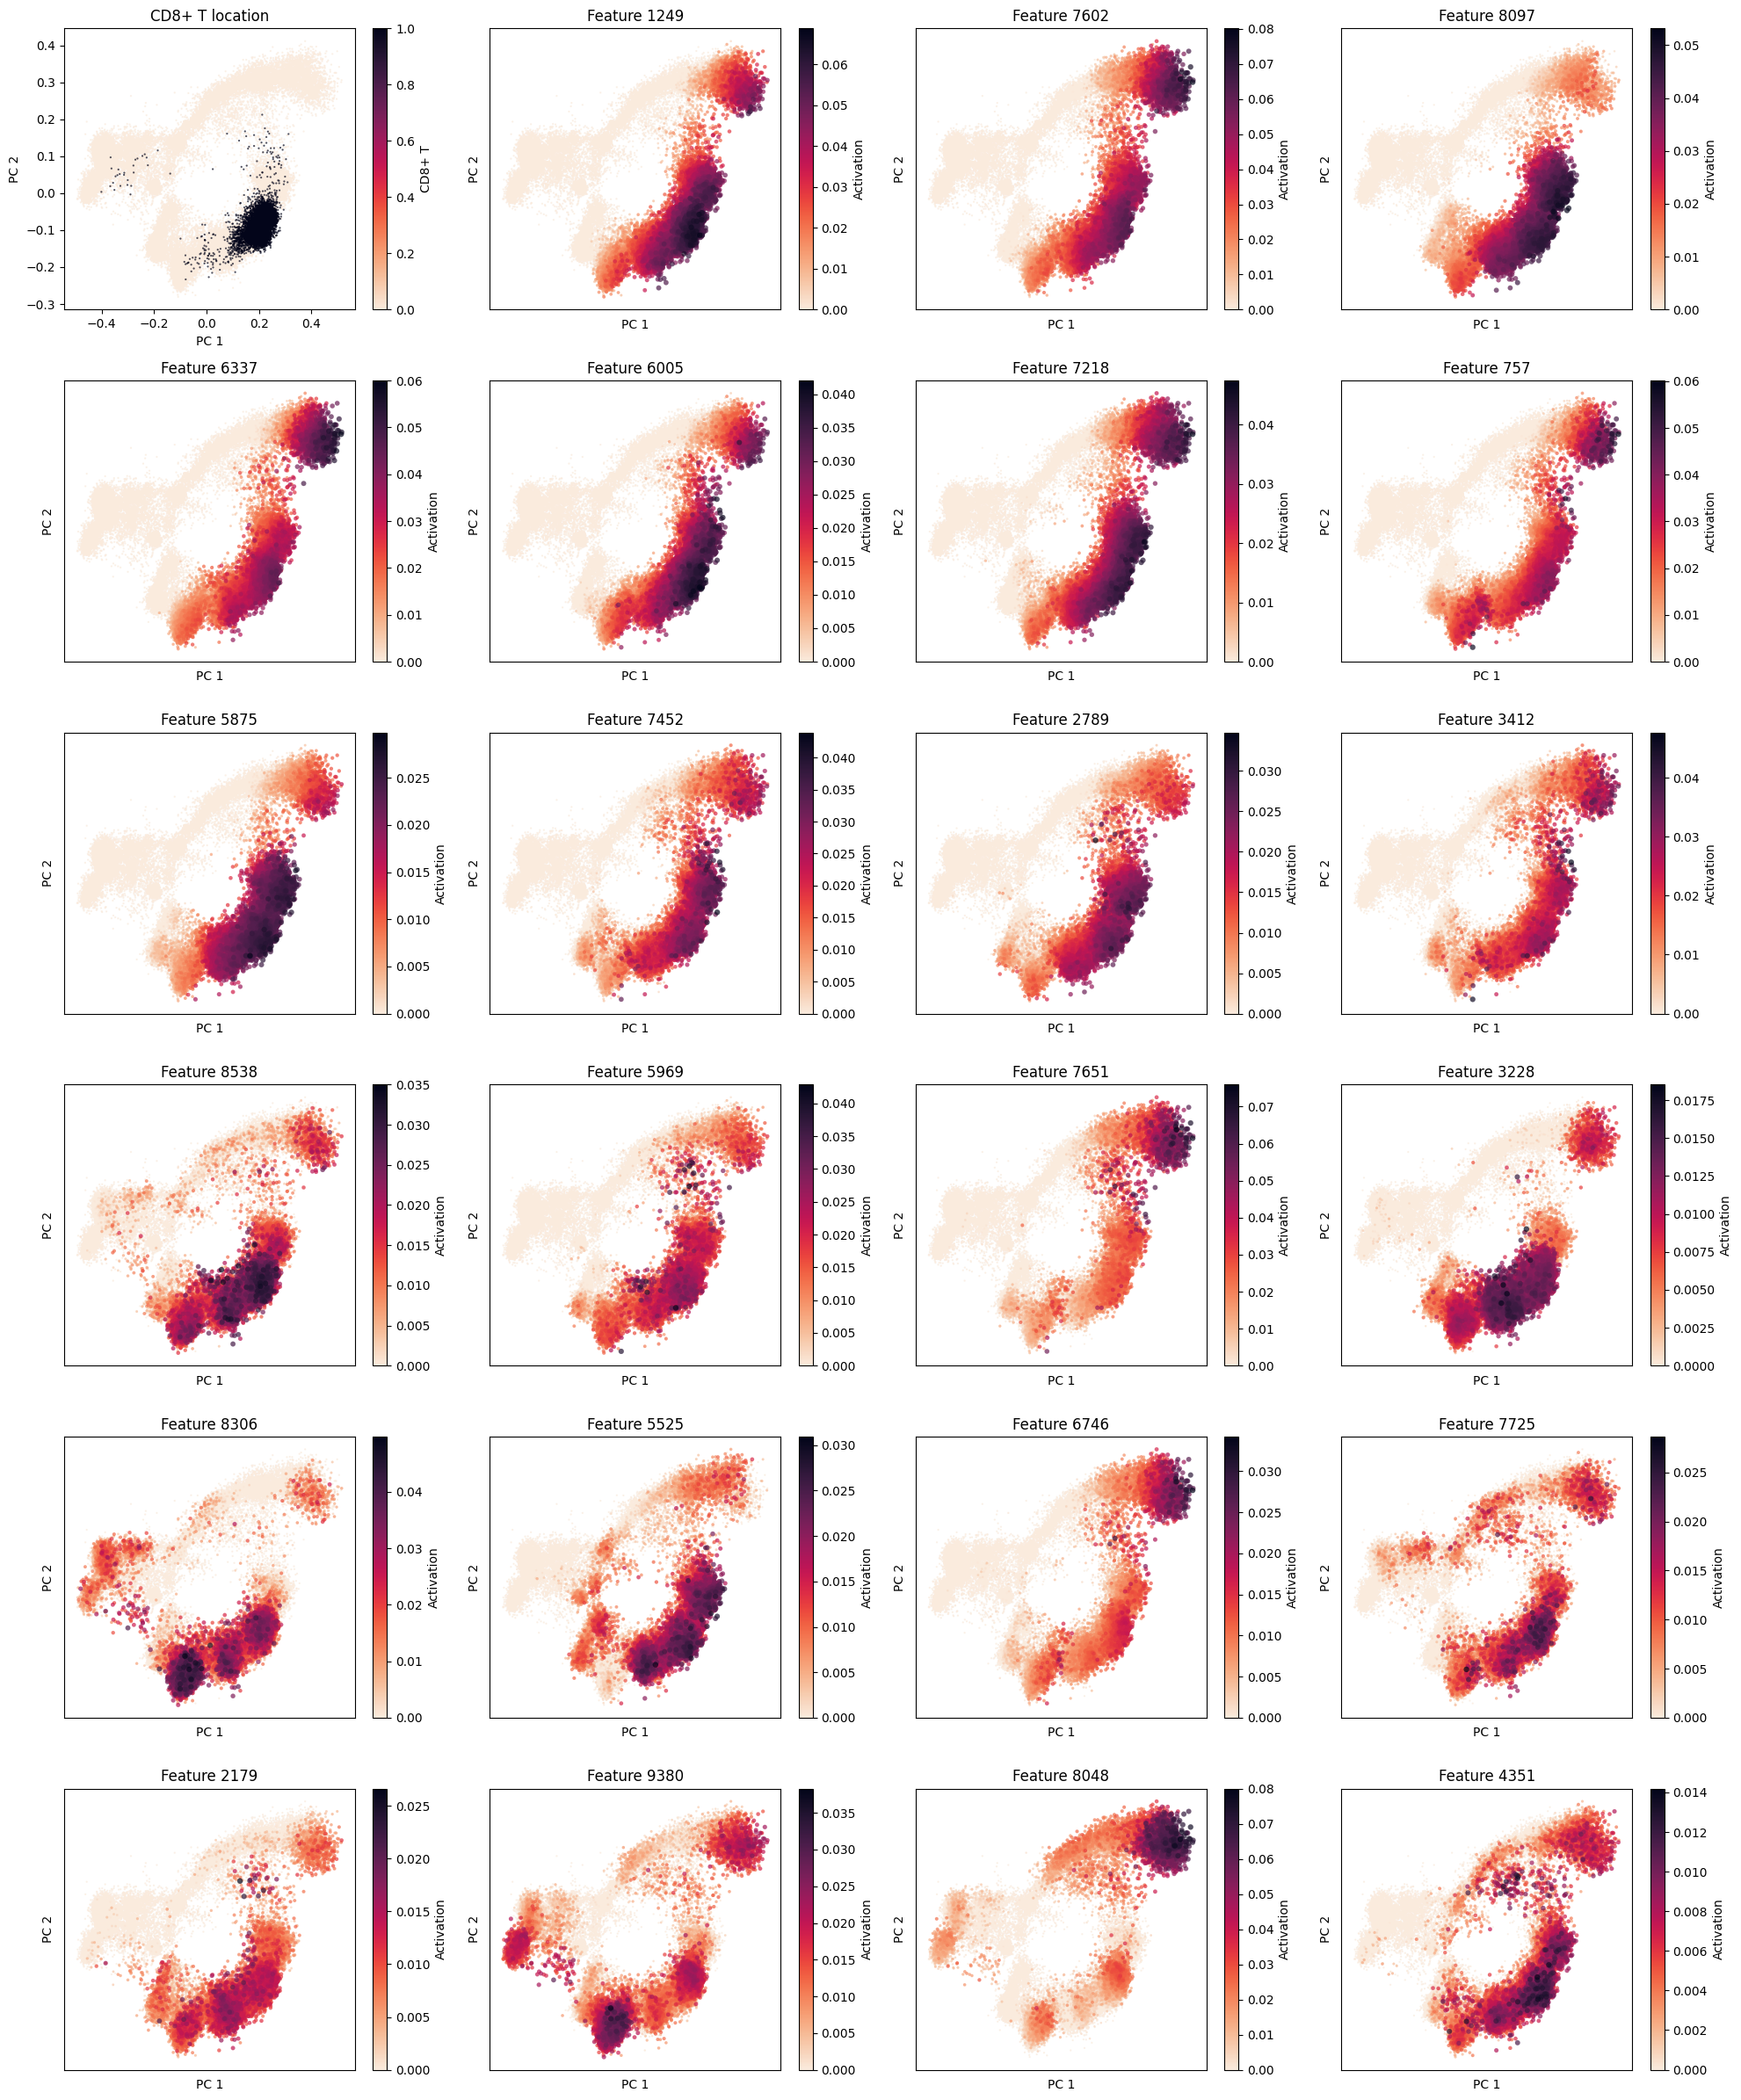

In [27]:
plot_multi_by_ct('CD8+ T')